# Importing necessary library

In [1]:
import sys
sys.path.insert(0, '../src')
from terminal_script import read_data
from terminal_script import plot_top_10_by_state
from terminal_script import two_sample_t_test
from terminal_script import t_test_against_others
from terminal_script import t_test_weather_quan
from terminal_script import t_test_weather_city
from terminal_script import airline_t_test
import importlib
importlib.reload(sys.modules['terminal_script'])

<module 'terminal_script' from '../src/terminal_script.py'>

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Rolling 12-months data

In [3]:
df_02 = read_data('../data/2019_02_ALL.csv')
df_03 = read_data('../data/2019_03_ALL.csv')
df_04 = read_data('../data/2019_04_ALL.csv')
df_05 = read_data('../data/2019_05_ALL.csv')
df_06 = read_data('../data/2019_06_ALL.csv')
df_07 = read_data('../data/2019_07_ALL.csv')
df_08 = read_data('../data/2019_08_ALL.csv')
df_09 = read_data('../data/2019_09_ALL.csv')
df_10 = read_data('../data/2019_10_ALL.csv')
df_11 = read_data('../data/2019_11_ALL.csv')
df_12 = read_data('../data/2019_12_ALL.csv')
df_01 = read_data('../data/2020_01_ALL.csv')

In [4]:
frames = [df_02,df_03,df_04,df_05,df_06,df_07,df_08,df_09,df_10,df_11,df_12,df_01]

In [5]:
df_one_year = pd.concat(frames)

# Runway Data

In [78]:
df_runway = pd.read_csv('../data/CA_runway_data.csv', usecols=['SiteNumber','State','RunwayID','RunwayLength','RunwayWidth'])

In [79]:
df_runway.head(5)

,SiteNumber,State,RunwayID,RunwayLength,RunwayWidth
0,01213.01*H,CA,'H1,20,20
1,01216.*A,CA,'07/25,3360,100
2,01216.*A,CA,'16/34,2040,100
3,01216.1*A,CA,'07/25,5875,80
4,01216.15*H,CA,'H1,70,70


In [80]:
ca_five_code = ['01818.*A','01971.*A','02187.*A','02170.*A','02204.*A'] 
ca_five = df_runway[(df_runway['SiteNumber'].isin(ca_five_code)) & (df_runway['RunwayLength'] > 0) ]
ca_five

,SiteNumber,State,RunwayID,RunwayLength,RunwayWidth
546,01818.*A,CA,'06L/24R,8926,150
547,01818.*A,CA,'06R/24L,10885,150
548,01818.*A,CA,'07L/25R,12923,150
549,01818.*A,CA,'07R/25L,11095,200
641,01971.*A,CA,'10L/28R,5458,150
642,01971.*A,CA,'10R/28L,6213,150
643,01971.*A,CA,'12/30,10520,150
644,01971.*A,CA,'15/33,3376,75
836,02170.*A,CA,'09/27,9400,200
851,02187.*A,CA,'01L/19R,7650,200


In [81]:
ca_five_pivot_runway = ca_five.groupby(['SiteNumber']).agg(
    total_runway=pd.NamedAgg(column='RunwayID',aggfunc='count'),
    avg_length=pd.NamedAgg(column='RunwayLength',aggfunc='mean'),
    avg_width=pd.NamedAgg(column='RunwayWidth',aggfunc='mean')
).reset_index()
ca_five_pivot_runway

,SiteNumber,total_runway,avg_length,avg_width
0,01818.*A,4,10957.25,162.50
1,01971.*A,4,6391.75,131.25
2,02170.*A,1,9400.00,200.00
3,02187.*A,4,9887.75,200.00
4,02204.*A,2,11000.00,150.00


In [82]:
ca_five_dict = {'01818.*A':'Los Angeles, CA','01971.*A':'Oakland, CA','02187.*A': 'San Francisco, CA','02170.*A': 'San Diego, CA','02204.*A': 'San Jose, CA'}
ca_five_pivot_runway.replace(to_replace={'SiteNumber': {'01818.*A':'Los Angeles, CA','01971.*A':'Oakland, CA','02187.*A': 'San Francisco, CA','02170.*A': 'San Diego, CA','02204.*A': 'San Jose, CA'}}, inplace=True)

In [83]:
ca_five_pivot_runway

,SiteNumber,total_runway,avg_length,avg_width
0,"Los Angeles, CA",4,10957.25,162.50
1,"Oakland, CA",4,6391.75,131.25
2,"San Diego, CA",1,9400.00,200.00
3,"San Francisco, CA",4,9887.75,200.00
4,"San Jose, CA",2,11000.00,150.00


In [84]:
ca_five_list = ['Los Angeles, CA','Oakland, CA','San Francisco, CA','San Diego, CA','San Jose, CA']
ca_five_filtered = df_one_year[df_one_year['ORIGIN_CITY_NAME'].isin(ca_five_list)]
df_one_year[df_one_year['ORIGIN_CITY_NAME'].isin(ca_five_list)]['ORIGIN_CITY_NAME'].unique()

array(['Los Angeles, CA', 'San Francisco, CA', 'San Jose, CA',
       'San Diego, CA', 'Oakland, CA'], dtype=object)

In [85]:
ca_five_pivot_flight = ca_five_filtered.groupby(['ORIGIN_CITY_NAME']).agg(
    total_flight=pd.NamedAgg(column='ORIGIN_CITY_NAME',aggfunc='count')
).sort_values(by='total_flight',ascending=False).reset_index()

In [86]:
ca_five_pivot_flight

,ORIGIN_CITY_NAME,total_flight
0,"Los Angeles, CA",219763
1,"San Francisco, CA",170913
2,"San Diego, CA",93454
3,"San Jose, CA",63088
4,"Oakland, CA",52979


In [87]:
ca_five_combine = ca_five_pivot_flight.join(ca_five_pivot_runway.set_index('SiteNumber'),on='ORIGIN_CITY_NAME')

In [88]:
ca_five_combine

,ORIGIN_CITY_NAME,total_flight,total_runway,avg_length,avg_width
0,"Los Angeles, CA",219763,4,10957.25,162.50
1,"San Francisco, CA",170913,4,9887.75,200.00
2,"San Diego, CA",93454,1,9400.00,200.00
3,"San Jose, CA",63088,2,11000.00,150.00
4,"Oakland, CA",52979,4,6391.75,131.25


In [89]:
ca_five_combine['fl_per_day'] = ca_five_combine['total_flight'] / 365
ca_five_combine['fl_per_rw'] = ca_five_combine['total_flight'] / ca_five_combine['total_runway']
ca_five_combine['fl_per_rw_per_day'] = ca_five_combine['total_flight'] / ca_five_combine['total_runway'] / 365

In [90]:
ca_five_combine

,ORIGIN_CITY_NAME,total_flight,total_runway,avg_length,avg_width,fl_per_day,fl_per_rw,fl_per_rw_per_day
0,"Los Angeles, CA",219763,4,10957.25,162.50,602.090411,54940.75,150.522603
1,"San Francisco, CA",170913,4,9887.75,200.00,468.254795,42728.25,117.063699
2,"San Diego, CA",93454,1,9400.00,200.00,256.038356,93454.00,256.038356
3,"San Jose, CA",63088,2,11000.00,150.00,172.843836,31544.00,86.421918
4,"Oakland, CA",52979,4,6391.75,131.25,145.147945,13244.75,36.286986


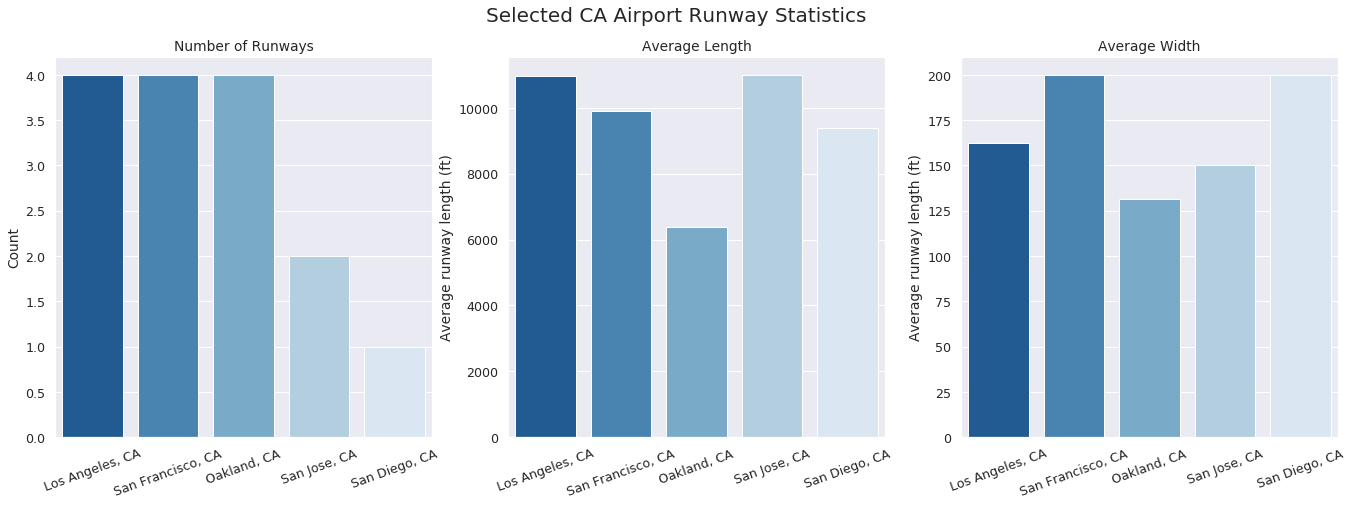

In [358]:
fig, axes = plt.subplots(1,3,figsize=(23,7))
sns.set(font_scale=1.15)

sns.barplot(x='ORIGIN_CITY_NAME',y='total_runway',data=ca_five_combine.sort_values('total_runway',ascending=False),palette='Blues_r',ax=axes[0])
sns.barplot(x='ORIGIN_CITY_NAME',y='avg_length',data=ca_five_combine.sort_values('total_runway',ascending=False),palette='Blues_r',ax=axes[1])
sns.barplot(x='ORIGIN_CITY_NAME',y='avg_width',data=ca_five_combine.sort_values('total_runway',ascending=False),palette='Blues_r',ax=axes[2])

axes[0].set_ylabel('Count')
axes[0].set_title('Number of Runways')
axes[1].set_ylabel('Average runway length (ft)')
axes[1].set_title('Average Length')
axes[2].set_ylabel('Average runway length (ft)')
axes[2].set_title('Average Width')
for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')
plt.figtext(.5,.95,'Selected CA Airport Runway Statistics', fontsize=20, ha='center')
plt.savefig('../img/runway_ca_1.png', bbox_inches = "tight")

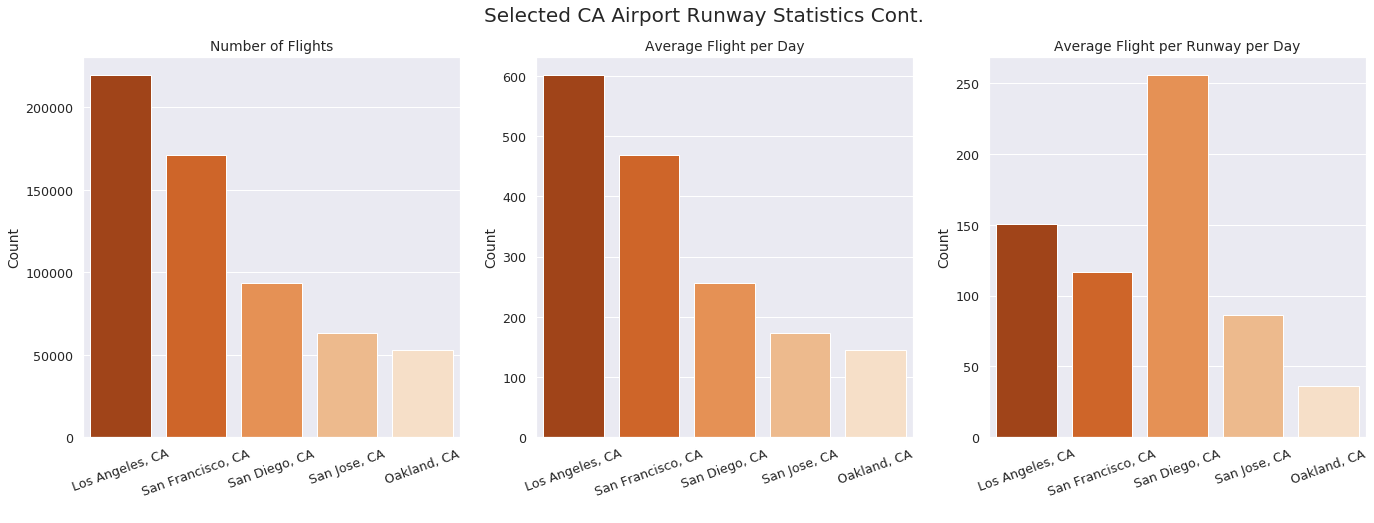

In [359]:
fig, axes = plt.subplots(1,3,figsize=(23,7))
sns.set(font_scale=1.15)

sns.barplot(x='ORIGIN_CITY_NAME',y='total_flight',data=ca_five_combine.sort_values('total_flight',ascending=False),palette='Oranges_r',ax=axes[0])
sns.barplot(x='ORIGIN_CITY_NAME',y='fl_per_day',data=ca_five_combine.sort_values('total_flight',ascending=False),palette='Oranges_r',ax=axes[1])
sns.barplot(x='ORIGIN_CITY_NAME',y='fl_per_rw_per_day',data=ca_five_combine.sort_values('total_flight',ascending=False),palette='Oranges_r',ax=axes[2])

axes[0].set_ylabel('Count')
axes[0].set_title('Number of Flights')
axes[1].set_ylabel('Count')
axes[1].set_title('Average Flight per Day')
axes[2].set_ylabel('Count')
axes[2].set_title('Average Flight per Runway per Day')
for ax in fig.axes:
    ax.set_xlabel(' ')
    plt.setp(ax.get_xticklabels(), rotation=20, horizontalalignment='center')
plt.figtext(.5,.95,'Selected CA Airport Runway Statistics Cont.', fontsize=20, ha='center')
plt.savefig('../img/runway_ca_2.png', bbox_inches = "tight")